# A first attempt at training on the maria data

Here we are trying to train a transformer on the TODs directly, mapping to the CMB tod component.

## Step 1: Generate data with maria

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

import maria

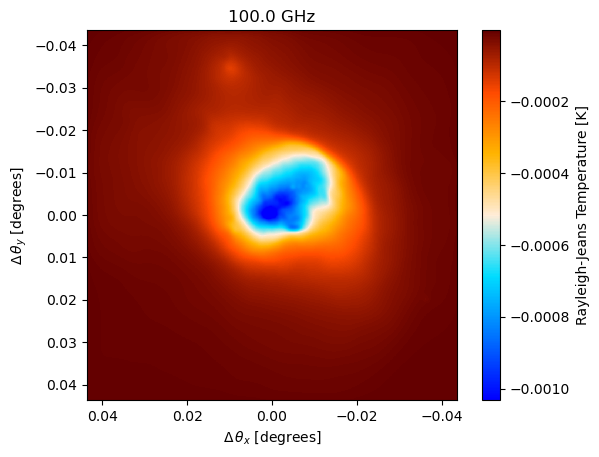

In [2]:
map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=-8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()

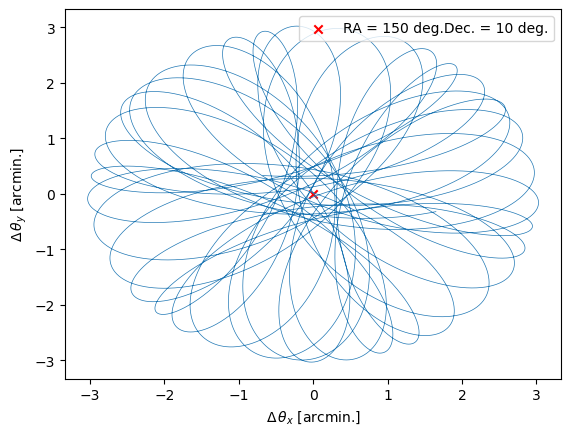

In [3]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

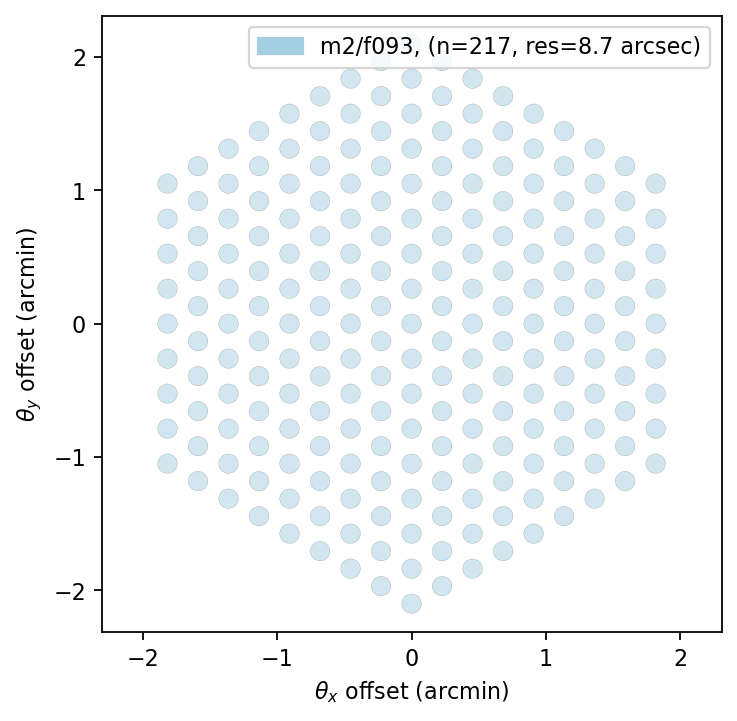

In [4]:
instrument = maria.get_instrument('MUSTANG-2')
instrument.plot()

In [5]:
sim = maria.Simulation(instrument, 
                       plan=plan,
                       site="llano_de_chajnantor", 
                       map=input_map,
                       atmosphere="2d",
                       cmb="generate",
                      )

tod = sim.run()

2024-07-15 16:25:25.458 INFO: Constructed instrument.
2024-07-15 16:25:25.459 INFO: Constructed plan.
2024-07-15 16:25:25.460 INFO: Constructed site.
2024-07-15 16:25:26.030 INFO: Constructed boresight.
2024-07-15 16:25:26.284 INFO: Constructed offsets.


Initialized base in 826 ms.


Generating CMB:   0%|          | 0/1 [00:00<?, ?it/s]2024-07-15 16:25:28.278 INFO: Sigma is 0.000000 arcmin (0.000000 rad) 
2024-07-15 16:25:28.280 INFO: -> fwhm is 0.000000 arcmin
Generating noise: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]
Generating atmosphere: 4it [00:00,  4.00it/s]
Sampling map (m2/f093): 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


Data and components are stored in tod.components and tod.data:

In [6]:
tod.components

{'atmosphere': dask.array<array, shape=(217, 30000), dtype=float32, chunksize=(217, 30000), chunktype=numpy.ndarray>,
 'cmb': dask.array<array, shape=(217, 30000), dtype=float32, chunksize=(217, 30000), chunktype=numpy.ndarray>,
 'map': dask.array<array, shape=(217, 30000), dtype=float32, chunksize=(217, 30000), chunktype=numpy.ndarray>,
 'noise': dask.array<setitem, shape=(217, 30000), dtype=float32, chunksize=(217, 30000), chunktype=numpy.ndarray>}

In [7]:
tod.data

dask.array<add, shape=(217, 30000), dtype=float32, chunksize=(217, 30000), chunktype=numpy.ndarray>

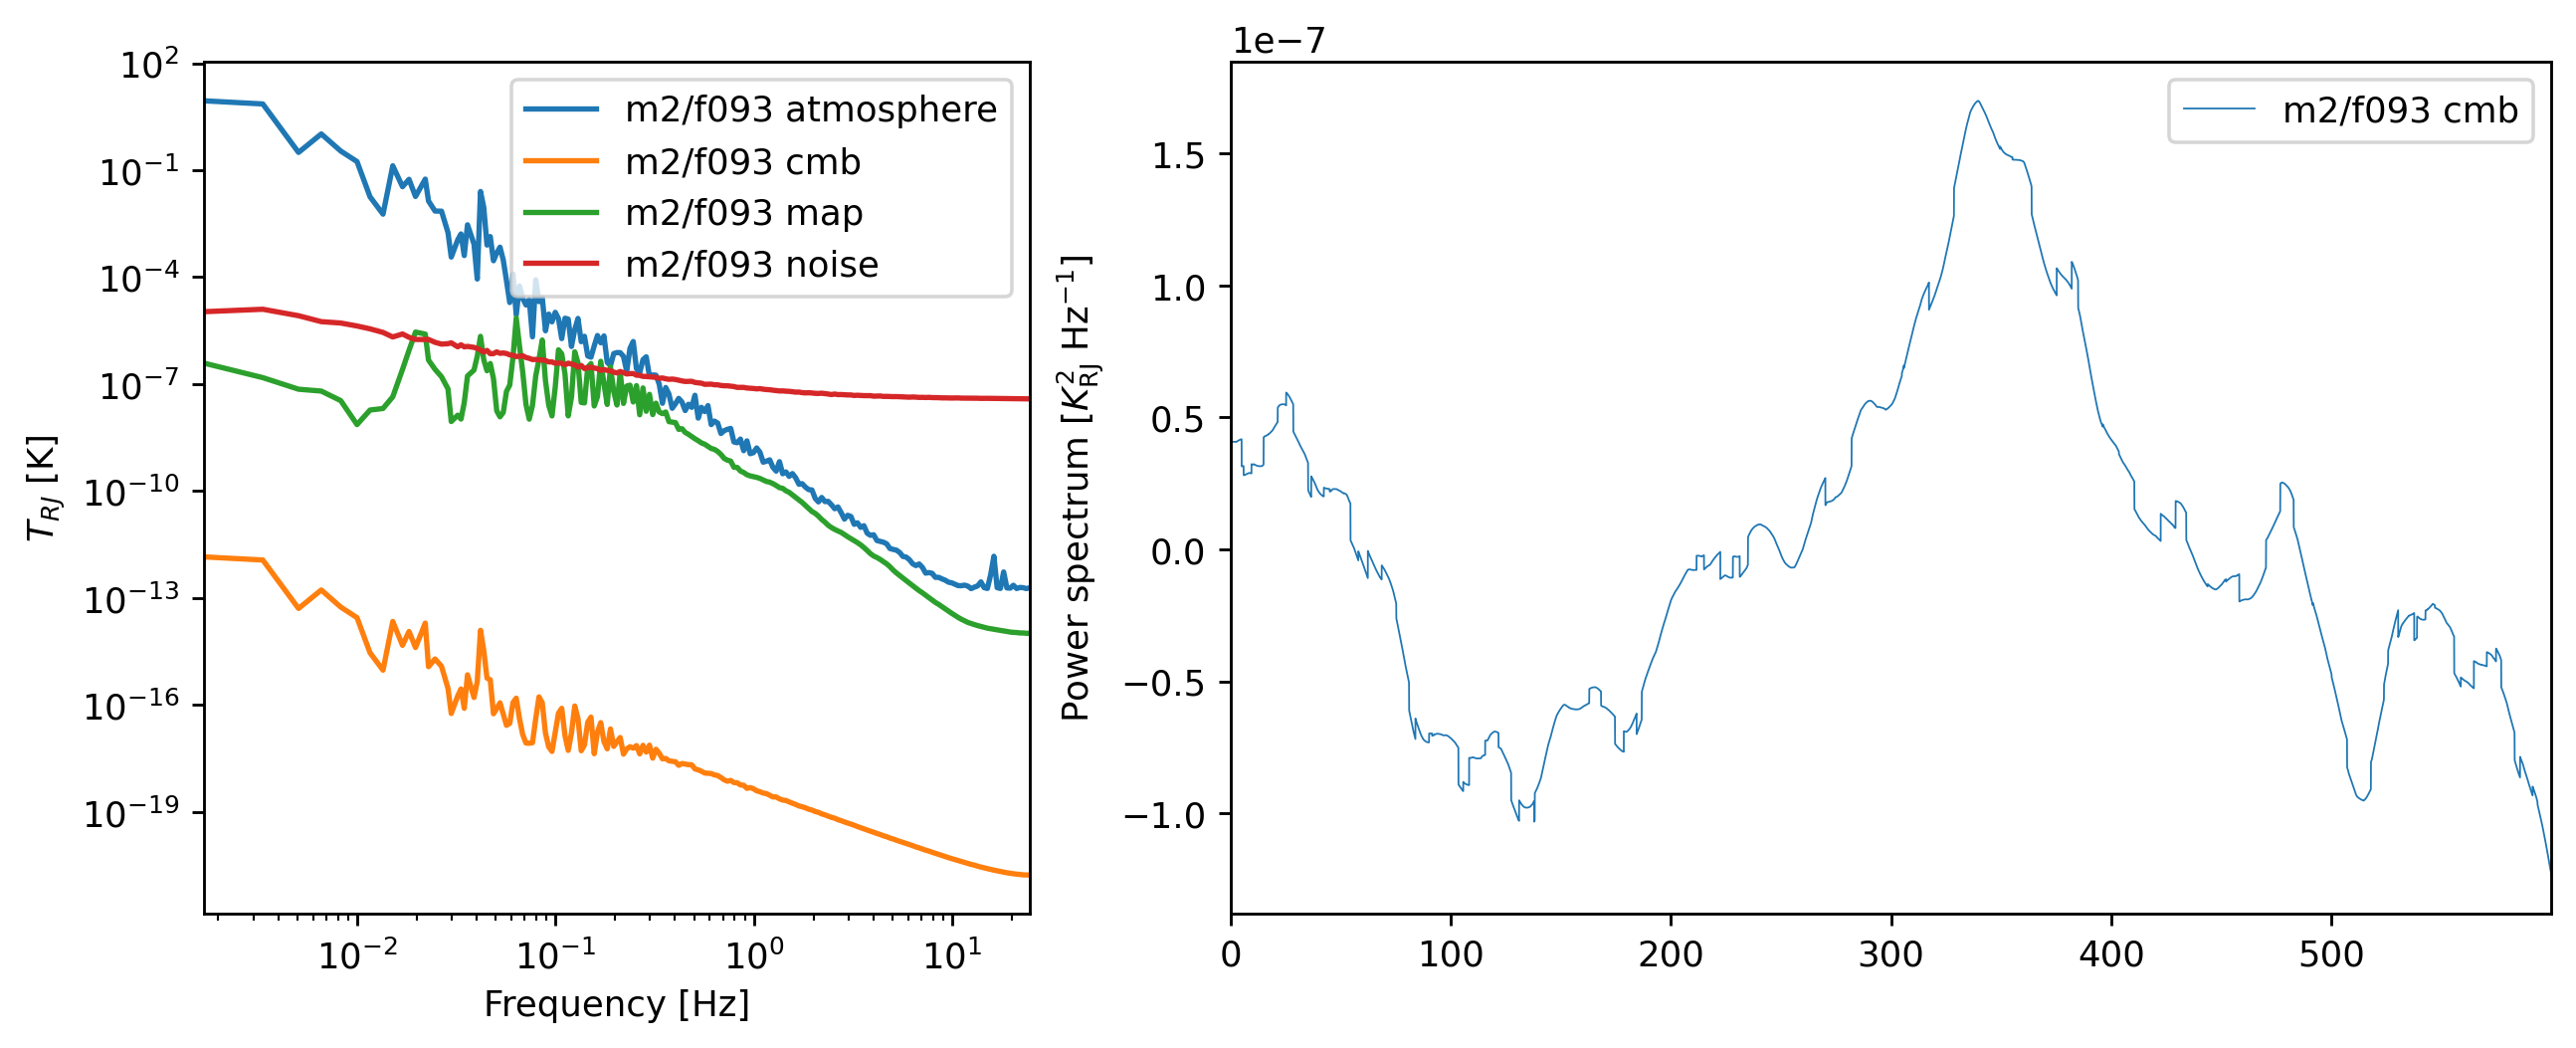

In [8]:
tod.plot(calibrate=True, detrend=True)

## Baseline reco to compare to:

baseline denoised TOD does not exist anymore?

calling _run for band m2/f093


Running mapper (m2/f093):   0%|          | 0/1 [00:00<?, ?it/s]

self.tods: [TOD(shape=(217, 30000), fields=['atmosphere', 'cmb', 'map', 'noise'])]
TOD(shape=(217, 30000), fields=['atmosphere', 'cmb', 'map', 'noise'])


Running mapper (m2/f093): 100%|██████████| 1/1 [00:04<00:00,  4.15s/it]


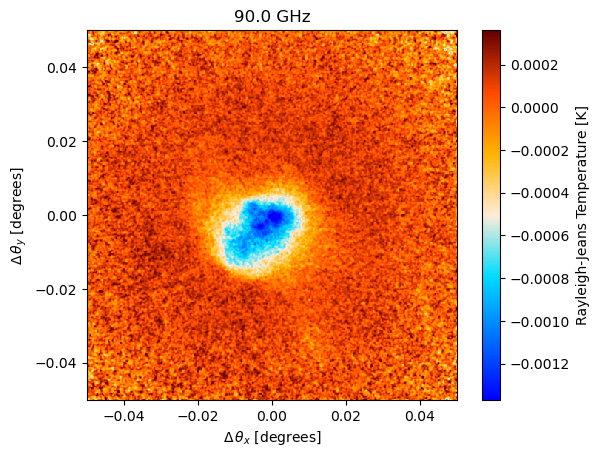

In [9]:
from maria.map.mappers import BinMapper

mapper = BinMapper(center=(150, 10), 
                   frame="ra_dec", 
                   width=0.1, 
                   height=0.1,
                   resolution=2e-4,
                   tod_postprocessing={
                        "remove_modes": {"n": 1},
                        # "highpass": {"f": 0.01},
                        "despline": {"spacing": 10},
                    },
                    map_postprocessing={
                        "gaussian_filter": {"sigma": 1},
                        "median_filter": {"size": 1},
                    },
                  )

mapper.add_tods(tod)
output_map = mapper.run()

output_map.plot()

In [10]:
# TODO: Make plot of baseline PS. Broken atm, since `mapper.DATA` does not exist anymore.
# See working: https://github.com/thomaswmorris/maria/blob/f0ea09ee2e97d70bfb07bbdfb520aa4ebd79ac55/docs/source/tutorials/MUSTANG-2_cluster.ipynb
# vs new: https://thomaswmorris.com/maria/tutorials/MUSTANG-2_cluster.html

# dt = (tod.time[1] - tod.time[0]).compute()
# data = mapper.DATA

# # visualize powerspectrum
# # -----------------------
# f, ps = sp.signal.periodogram(data, fs=1/dt, window="tukey")

# fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=256, tight_layout=True, gridspec_kw={'width_ratios': [1, 1.6]})
# fig.suptitle('Raw time streams')

# for i in range(-20,20,2): axes[0].plot(np.logspace(-7, 3,100), np.logspace(-7, 3,100) ** (-3)/1e11/(10**i), c = 'gray', alpha = 0.2, ls = '--', lw = 1)

# axes[0].plot(f[1:], ps.mean(axis=0)[1:], label="Combined", alpha = 0.7, c = 'C0', lw = 1.5, ls = '-')

# axes[0].set_xlabel(r"$\mathcal{f}$ [Hz]"), 
# axes[0].set_ylabel(r"$\mathcal{P}_{\rm Hz}[K_{\rm RJ}^2~{\rm Hz}^{-1}]$")
# axes[0].loglog()
# axes[0].legend(loc = 1, frameon=False)
# axes[0].axis(xmin=1e-2, xmax = 2e2, ymin = 1e-10, ymax = 1e2)

# axes[1].set_xlabel('Time [minutes]'), axes[1].set_ylabel("\n"+r'$I_\nu$ [$K_{\rm RJ}$]')
# axes[1].plot((tod.time - tod.time[0])/60, data[0], label = 'Real', alpha = 1., c = 'C0', lw = 1, ls = '-')
# plt.show()

## Step 2: Set up transformer

Question: How do we tokenise? Since we do already have numbers, maybe we don't need to? -> Yes!

In [11]:
tod_train = sim.run()
tod_val = sim.run()
tod_test = sim.run()

Generating noise: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
Generating atmosphere: 2it [00:00,  4.59it/s]

Generating atmosphere: 4it [00:00,  4.13it/s]
Generating noise: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]
Generating atmosphere: 4it [00:00,  4.03it/s]
Generating noise: 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]
Generating atmosphere: 4it [00:01,  3.13it/s]
Sampling map (m2/f093): 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


In [12]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cuda')
torch.cuda.set_device(2) # which GPU to use
torch.set_num_threads(4) # how many threads to fill workers with
print("Using device:", DEVICE)

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
# MAXLEN = 30_000 # out of memory!
MAXLEN = 500
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                #  maxlen: int = 128):
                 maxlen: int = MAXLEN):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                #  src_vocab_size: int,
                #  tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.src_inlin = nn.Linear(217, emb_size)
        self.tgt_inlin = nn.Linear(217, emb_size)
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        # self.generator = nn.Linear(emb_size, tgt_vocab_size)
        # self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        # self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)
        self.tgt_outlin = nn.Linear(emb_size, 217)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                # src_padding_mask: Tensor,
                # tgt_padding_mask: Tensor,
                # memory_key_padding_mask: Tensor
                ):
        src_emb = self.positional_encoding(self.src_inlin(src))
        tgt_emb = self.positional_encoding(self.tgt_inlin(trg))
        
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask,
                                # src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
                                src_is_causal = False, tgt_is_causal = True)
        # return self.generator(outs)
        
        return self.tgt_outlin(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            # self.src_inlin(src)), src_mask, src_is_causal = False)
                            self.src_inlin(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        # print("MARKER1:", self.tgt_inlin(tgt).shape)
        # print("SUPERMARKER", self.tgt_inlin(tgt).unsqueeze(1).shape)
        # print("MARKER2:", self.positional_encoding(self.tgt_inlin(tgt).unsqueeze(1)).shape)
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_inlin(tgt).unsqueeze(1)), memory, tgt_mask, tgt_is_causal = True)

Using device: cuda


In [13]:
?Transformer

Init signature:
Transformer(
    d_model: int = 512,
    nhead: int = 8,
    num_encoder_layers: int = 6,
    num_decoder_layers: int = 6,
    dim_feedforward: int = 2048,
    dropout: float = 0.1,
    activation: Union[str, Callable[[torch.Tensor], torch.Tensor]] = <function relu at 0x7fcb50927560>,
    custom_encoder: Optional[Any] = None,
    custom_decoder: Optional[Any] = None,
    layer_norm_eps: float = 1e-05,
    batch_first: bool = False,
    norm_first: bool = False,
    bias: bool = True,
    device=None,
    dtype=None,
) -> None
Docstring:     
A transformer model.

User is able to modify the attributes as needed. The architecture
is based on the paper "Attention Is All You Need". Ashish Vaswani, Noam Shazeer,
Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Lukasz Kaiser, and
Illia Polosukhin. 2017. Attention is all you need. In Advances in Neural Information
Processing Systems, pages 6000-6010.

Args:
    d_model: the number of expected features in the encoder/d

In [14]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    # src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    # tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    # return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask
    return src_mask, tgt_mask

In [15]:
torch.manual_seed(0)

EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
# BATCH_SIZE = 200
BATCH_SIZE = 512
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/scratch/users/jwuerzin/miniconda3/envs/maria/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [16]:
print("tod shape:", tod_train.data.compute().shape)
maxlen = 100

testtod = tod_train.data.compute()[:,:maxlen]
print("testtod shape:", testtod.shape)
print(testtod)

tod shape: (217, 30000)
testtod shape: (217, 100)
[[12.156586  12.155684  12.1556015 ... 12.154062  12.154403  12.154444 ]
 [12.156581  12.156221  12.156307  ... 12.15486   12.154454  12.1546135]
 [12.155706  12.156149  12.156064  ... 12.153782  12.154038  12.153976 ]
 ...
 [12.1599    12.159323  12.159405  ... 12.157742  12.157555  12.157997 ]
 [12.154456  12.154594  12.154304  ... 12.152606  12.15224   12.152502 ]
 [12.158383  12.158435  12.158307  ... 12.156186  12.156507  12.156792 ]]


In [17]:
seq_len = 3
batch_size = 5

i_start = torch.randint(0, maxlen-seq_len, size=(batch_size,))

print(i_start)

range_tensor = torch.arange(seq_len).unsqueeze(1)  # Shape: (seq_len, 1)
# range_tensor = torch.arange(seq_len)
print(range_tensor)

indices = (i_start + range_tensor).T.reshape(-1)
# indices = (i_start + range_tensor)
print("indices:", indices)

tensor([23, 25, 32, 81, 73])
tensor([[0],
        [1],
        [2]])
indices: tensor([23, 24, 25, 25, 26, 27, 32, 33, 34, 81, 82, 83, 73, 74, 75])


In [18]:
def give_batch(xdata: torch.Tensor, cmbdata: torch.Tensor, batch_size: int = 512, seq_len: int = 128):
    '''Makes batch_size batches with size seq_len from xdata and cmbdata.
    Returns in shape (seq_len, batch_size, 217).
    '''
    
    # pick random start positions
    i_start = torch.randint(0, 30_000-seq_len, size=(batch_size,))
    
    # create tensor with offsets from start positions
    range_tensor = torch.arange(seq_len).unsqueeze(1)  # Shape: (seq_len, 1)

    # Broadcast and add to i_start to get indices for all sequences
    indices = (i_start + range_tensor).T.reshape(-1)  # Shape: (seq_len * batch_size,)

    # Gather the sequences
    xdata_i = xdata[indices].reshape(seq_len, batch_size, 217)  # Shape: (seq_len, batch_size, feature_dim)
    cmbdata_i = cmbdata[indices].reshape(seq_len, batch_size, 217)
    
    return xdata_i, cmbdata_i

testtod_data = tod.data.compute()[:,:100]
testtod_cmb = tod.components['cmb'].compute()[:,:100]
print("testtod_data shape:", testtod_data.shape)
print(testtod_data)

# in full:
give_batch(torch.Tensor(tod.data.compute().T), torch.Tensor(tod.components['cmb'].compute().T))[0].shape

testtod_data shape: (217, 100)
[[12.166403  12.166097  12.166338  ... 12.165879  12.165892  12.166103 ]
 [12.165901  12.165941  12.166177  ... 12.166005  12.166037  12.166019 ]
 [12.1659975 12.165865  12.165409  ... 12.165263  12.165273  12.165743 ]
 ...
 [12.1696615 12.169953  12.16983   ... 12.1694565 12.169293  12.169404 ]
 [12.164285  12.164144  12.164222  ... 12.163937  12.163775  12.16388  ]
 [12.167942  12.168197  12.168391  ... 12.167795  12.167579  12.167929 ]]


torch.Size([128, 512, 217])

In [19]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer, xdata, cmbdata):
    model.train()
    losses = 0
    # train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    # for src, tgt in train_dataloader:
    
    for i in range(30_000//BATCH_SIZE):
    # for i in range(10):
        # print("HERE", i, 30_000//BATCH_SIZE)
        src, tgt = give_batch(xdata=xdata, cmbdata=cmbdata, batch_size=BATCH_SIZE, seq_len=128) # TODO: Too slow! Needs to be vectorised!!
        
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        # src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        src_mask, tgt_mask = create_mask(src, tgt_input)

        # logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        logits = model(src, tgt_input, src_mask, tgt_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        # loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1)) #TODO: sizes mismatched here!
        loss = loss_fn(logits.reshape(-1), tgt_out.reshape(-1)) 
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / xdata.shape[0]

In [20]:
def evaluate(model, xdata, cmbdata):
    model.eval()
    losses = 0

    for i in range(30_000//BATCH_SIZE):
    # for i in range(10):
        src, tgt = give_batch(xdata=xdata, cmbdata=cmbdata, batch_size=BATCH_SIZE, seq_len=128) # TODO: Too slow! Needs to be vectorised!!
        
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        # src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        src_mask, tgt_mask = create_mask(src, tgt_input)

        # logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        logits = model(src, tgt_input, src_mask, tgt_mask)

        tgt_out = tgt[1:, :]
        # loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss = loss_fn(logits.reshape(-1), tgt_out.reshape(-1)) 
        losses += loss.item()

    return losses / xdata.shape[0]

In [21]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt
NUM_EPOCHS = 20
# NUM_EPOCHS = 3

train_losses = []
val_losses = []

xdata_train = torch.Tensor(tod_train.data.compute().T)
cmbdata_train = torch.Tensor(tod_train.components['cmb'].compute().T)
xdata_val = torch.Tensor(tod_val.data.compute().T)
cmbdata_val = torch.Tensor(tod_val.components['cmb'].compute().T)

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer, xdata_train, cmbdata_train)
    end_time = timer()
    val_loss = evaluate(transformer, xdata_val, cmbdata_val)
    
    train_losses += [train_loss,]
    val_losses += [val_loss,]
    print((f"Epoch: {epoch}, Train loss: {train_loss}, Val loss: {val_loss}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    # print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 0.00031781384895245235, Val loss: 2.0020348873610297e-06, Epoch time = 12.314s
Epoch: 2, Train loss: 0.00010219410769641399, Val loss: 1.426805751786257e-06, Epoch time = 12.101s
Epoch: 3, Train loss: 6.647975984960794e-05, Val loss: 1.4359991434806337e-06, Epoch time = 12.083s
Epoch: 4, Train loss: 5.017131101340056e-05, Val loss: 1.5106836004027477e-06, Epoch time = 12.074s
Epoch: 5, Train loss: 4.2337444300452865e-05, Val loss: 1.106870488729328e-06, Epoch time = 12.113s
Epoch: 6, Train loss: 3.6130449548363685e-05, Val loss: 9.855070481232057e-07, Epoch time = 12.126s
Epoch: 7, Train loss: 2.8315992932766677e-05, Val loss: 9.68255898139129e-07, Epoch time = 12.137s
Epoch: 8, Train loss: 1.8185919414584837e-05, Val loss: 7.41378593374975e-07, Epoch time = 12.212s
Epoch: 9, Train loss: 1.1487502620245019e-05, Val loss: 7.989238879720991e-07, Epoch time = 12.134s
Epoch: 10, Train loss: 8.21748364251107e-06, Val loss: 1.2684853844499836e-06, Epoch time = 12.113s
E

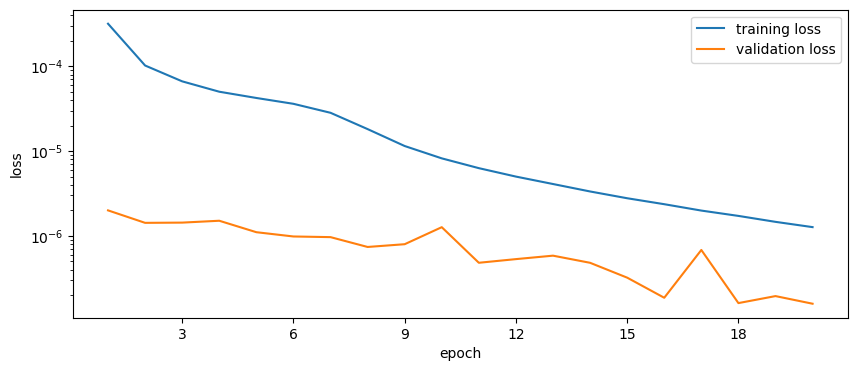

In [22]:
from matplotlib.ticker import MaxNLocator

fig, axes = plt.subplots(1, 1, figsize=(10,4))
axes.plot(np.linspace(1, len(train_losses), len(train_losses)), train_losses, label='training loss')
axes.plot(np.linspace(1, len(val_losses), len(val_losses)), val_losses, label='validation loss')
plt.legend()
plt.yscale('log')
plt.xlabel('epoch')
axes.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel('loss')
plt.show()

## Define functions to make predictions and plot testdata

In [23]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    # ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    # ys = torch.ones(1, 1).to(DEVICE)
    ys = torch.ones(1, 217).to(DEVICE) # one = BOS in language. Here use initial data value
    # ys = src[0]
    # print("ys:", ys)
    
    print(ys.shape)
    print(src.shape)
    
    for i in range(max_len-1):

        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        # print(ys.shape, memory.shape, tgt_mask.shape)
        
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        # print("outshape:", out.shape)
        
        # prob = model.generator(out[:, -1])
        prob = model.tgt_outlin(out[:, -1])
        
        # print("prob shape", prob.shape)
        
        # _, next_word = torch.max(prob, dim=1)
        # next_word = next_word.item()
        next_word = prob

        # print("ys:", ys.shape)
        # print("next_word", next_word.shape)
        ys = torch.cat([ys,
                        # torch.ones(1, 217).type_as(src.data).fill_(next_word)], dim=0)
                        next_word], dim=0)
        
        # print("ys after:", ys.shape)
        # print("ys full:", ys)
        
        # if next_word == EOS_IDX:
        #     break
    return ys

# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, xdata):
    model.eval()
    src = xdata.to(DEVICE)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    # print("maxlen=", num_tokens+5)
    tgt_tokens = greedy_decode(
        # model,  src, src_mask, max_len=num_tokens + 5).flatten()
        model,  src, src_mask, max_len=num_tokens)
    
    return tgt_tokens
    # return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [24]:
# xdata_test = torch.Tensor(tod_test.data.compute().T).unsqueeze(1)[:128]
xdata_test = torch.Tensor(tod_test.data.compute().T).unsqueeze(1)[:MAXLEN]

# [:128] # Take only batch size of xdata for now
print("src shape", xdata_test.shape)
cmb_pred = translate(transformer, xdata_test)

src shape torch.Size([500, 1, 217])
torch.Size([1, 217])
torch.Size([500, 1, 217])


In [25]:
def plotpred(tod_test, cmb_pred, detn, skipfirst=True):
    fig, axes = plt.subplots(2, 1, figsize=(10,4))
    if skipfirst:
        axes[0].plot(tod_test.components['cmb'].compute()[detn,:MAXLEN][10:], label=f"true cmb detector {detn}")
        axes[1].plot(cmb_pred.T[detn].to('cpu').detach().numpy()[10:], label=f"prediction det {detn}")
    else:
        axes[0].plot(tod_test.components['cmb'].compute()[detn,:MAXLEN], label=f"true cmb det {detn}")
        axes[1].plot(cmb_pred.T[detn].to('cpu').detach().numpy(), label=f"prediction det {detn}")
    axes[0].legend()
    axes[1].legend()
    plt.show()

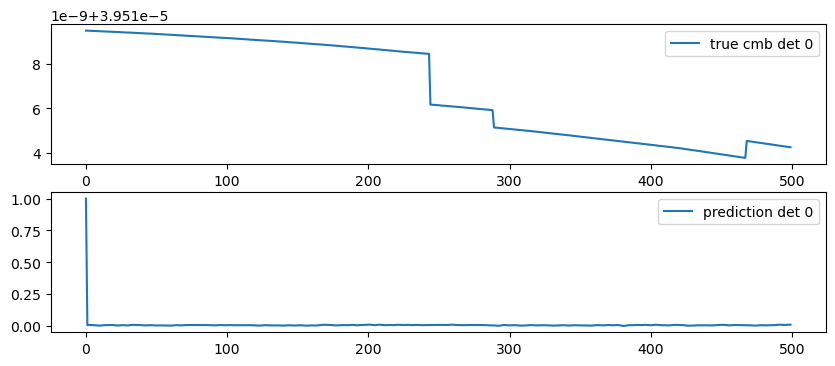

In [26]:
plotpred(tod_test, cmb_pred, 0, skipfirst=False)

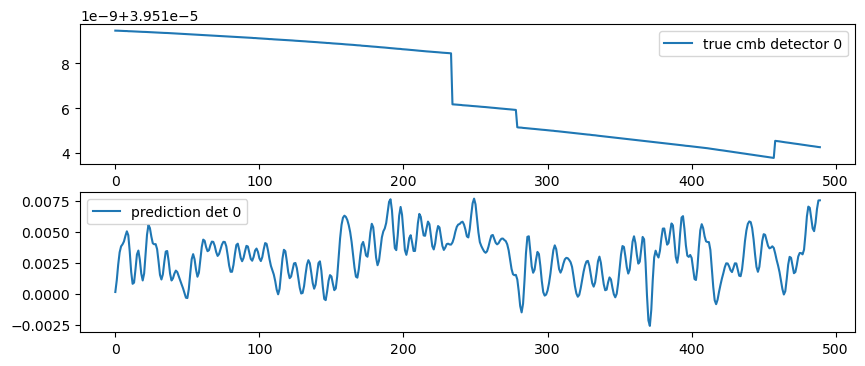

In [27]:
plotpred(tod_test, cmb_pred, 0)

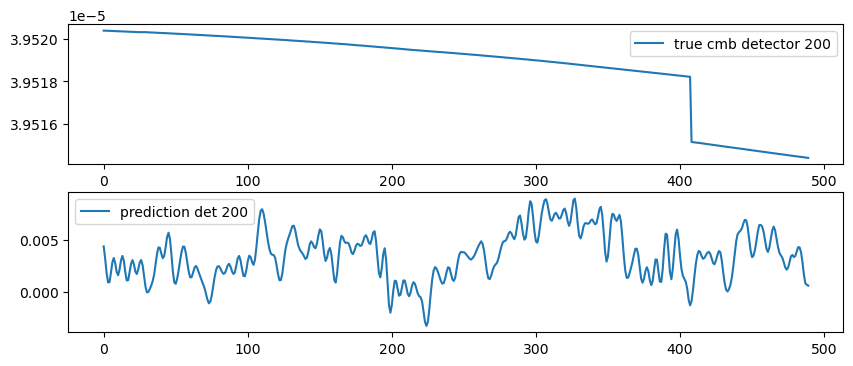

In [28]:
plotpred(tod_test, cmb_pred, 200)